In [2]:
%matplotlib inline
# NB: per eseguire questo notebook come file Python, commentare l'istruzione "%matplotlib inline" qui sopra e scegliere il menù "File -> Download as -> Python (.py)"
import numpy as np
import matplotlib.pyplot as plt
from sistema_meccanico_3gdl import *

M1 =  27.0
M2 =  120.0
M3 =  11246.0
K1 =  180000000.0
K2 =  60000000.0
K3 =  120000000.0
C1 =  50000.0
C2 =  46000.0
C3 =  240000.0
coordinate di partenza: y1=0.06, y2=0.06, y3=0.05


In [3]:
Ac,Bc,Cc,Dc = build_sistema_meccanico_3gdl()
print("Ac.shape = ",Ac.shape,", Bc.shape = ",Bc.shape,", Cc.shape = ",Cc.shape)

Ac.shape =  (6, 6) , Bc.shape =  (6, 2) , Cc.shape =  (1, 6)


In [4]:
# look into "sistema_meccanico_3gdl.build_sistema_meccanico_3gdl": the state vector 
# is defined as in the Appendix B of the lecture notes, x = [velocities; displacements], 
# where:
print("we control: ",Bc[:,0])
print("we measure: ",Cc[0,:])

we control:  [0.         0.00833333 0.         0.         0.         0.        ]
we measure:  [0. 0. 0. 1. 0. 0.]


In [5]:
# implicit Euler discretization:
Ts = 0.001
invm = np.linalg.inv(np.eye(Ac.shape[0]) - Ts*Ac)
A = invm.copy()
B = Ts * invm @ Bc[:,[0]]
n = A.shape[0]; print("n = ",n)
for i in range(A.shape[0]):
    if i==0:
        R = B.copy()
    else:
        R = np.hstack((R, A**i @ B))
    #endif
    print("rank(R) = ",np.linalg.matrix_rank(R)," , cond(R) = ",np.linalg.cond(R))
#endfor
G_R = R @ R.T

n =  6
rank(R) =  1  , cond(R) =  1.0
rank(R) =  2  , cond(R) =  12.506040364125813
rank(R) =  3  , cond(R) =  40145.36571969803
rank(R) =  4  , cond(R) =  1491774554.5717576
rank(R) =  5  , cond(R) =  1852326761282.1013
rank(R) =  5  , cond(R) =  8973070418388460.0


In [6]:
print(np.linalg.norm(G_R))
print(G_R.shape)

97282690697.13608
(6, 6)


In [7]:
for i in range(A.shape[0]):
    if i==0:
        O = Cc.copy()
    else:
        O = np.vstack((O, Cc @ A**i))
    #endif
    print("rank(O) = ",np.linalg.matrix_rank(O)," , cond(O) = ",np.linalg.cond(O))
#endfor
G_O = O.T @ O

rank(O) =  1  , cond(O) =  1.0
rank(O) =  2  , cond(O) =  2.489753035701957
rank(O) =  3  , cond(O) =  29.770325236706505
rank(O) =  4  , cond(O) =  24804.763894125084
rank(O) =  5  , cond(O) =  347569855.8137654
rank(O) =  6  , cond(O) =  4581439143293.163


In [8]:
help(np.linalg.eig)

Help on function eig in module numpy.linalg:

eig(a)
    Compute the eigenvalues and right eigenvectors of a square array.
    
    Parameters
    ----------
    a : (..., M, M) array
        Matrices for which the eigenvalues and right eigenvectors will
        be computed
    
    Returns
    -------
    w : (..., M) array
        The eigenvalues, each repeated according to its multiplicity.
        The eigenvalues are not necessarily ordered. The resulting
        array will be of complex type, unless the imaginary part is
        zero in which case it will be cast to a real type. When `a`
        is real the resulting eigenvalues will be real (0 imaginary
        part) or occur in conjugate pairs
    
    v : (..., M, M) array
        The normalized (unit "length") eigenvectors, such that the
        column ``v[:,i]`` is the eigenvector corresponding to the
        eigenvalue ``w[i]``.
    
    Raises
    ------
    LinAlgError
        If the eigenvalue computation does not converg

In [18]:
U_T = np.linalg.cholesky(G_R); #print(np.linalg.norm(U_T@U_T.T - G_R))
print(np.linalg.norm(U_T@U_T.T - G_R)/np.linalg.norm(G_R))
L = np.linalg.cholesky(G_O)
[W,Sigma,VT] = np.linalg.svd(U_T.T @ L); V = VT.T
print("Hankel singular values = ",Sigma)
if 1: # square root
    T = U_T @ W @ np.diag(Sigma**-0.5)
else:
    tmpM = U_T.T @ G_O @ U_T; print("cond(U_T.T @ G_O @ U_T) = ",np.linalg.cond(tmpM))
    [Sigmasq, K] = np.linalg.eig(tmpM); print("orth. check of K: ",np.linalg.norm(K.T@K - np.eye(K.shape[0])))
    Sigma = Sigmasq**0.5; print("Sigmasq = ",Sigmasq); print("Sigma = ",Sigma)
    Sigma = np.abs(Sigmasq)**0.5; print("Sigma = ",Sigma)
    T = np.diag(Sigma**0.5) @ K.T @ np.linalg.inv(U_T).T
#endif

1.568499899946662e-16
Hankel singular values =  [6.50901371e+01 1.12610839e-06 6.70617113e-09 9.07333767e-11
 7.52557588e-14 1.25165073e-19]


In [19]:
print(T.T @ G_O @ T)

[[ 6.50901371e+01 -6.34997483e-15  1.11519934e-16 -1.03375289e-16
  -4.22567797e-17  1.20813744e-15]
 [ 3.61904562e-15  1.12610840e-06 -1.04062235e-16  8.23875771e-17
   1.27208872e-17 -5.21913160e-18]
 [-3.47458215e-17  2.13135992e-18  6.70617113e-09  4.17055683e-20
   6.72749223e-21 -2.24584231e-19]
 [ 3.59193690e-17  8.83953204e-17 -2.16220625e-18  9.07333784e-11
   2.64431416e-19 -2.75233023e-19]
 [-2.91877802e-17  1.44618899e-17 -3.53673732e-19  2.79924419e-19
   7.52558020e-14 -1.92254936e-20]
 [ 1.15983760e-15 -1.84688947e-17  6.36681750e-19 -3.79666647e-19
  -5.81963148e-20  2.41722767e-19]]


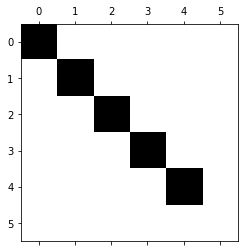

In [20]:
M = T.T @ G_O @ T
plt.figure(); plt.spy(M,precision=1.e-14); plt.show()

In [21]:
invT = np.linalg.inv(T)

In [22]:
print(invT @ G_R @ invT.T)

[[ 6.50901371e+01 -1.44074225e-15 -3.61798569e-16 -4.53581749e-16
   4.27751638e-20 -1.70198615e-20]
 [-7.73059049e-16  1.12610839e-06  6.32160761e-19 -1.43665938e-18
  -3.66707260e-20  2.73002786e-21]
 [-3.65147990e-16  9.65470308e-19  6.70617113e-09  5.24156243e-21
   1.33693067e-22 -1.00165235e-23]
 [-4.45176796e-16 -1.44927318e-18  3.46462822e-21  9.07333767e-11
  -2.00963489e-22  1.50421486e-23]
 [ 1.43486243e-19 -3.19776080e-20  7.63091793e-23 -1.73564223e-22
   7.52557588e-14  3.32466612e-25]
 [-2.13500270e-20  2.89979381e-21 -6.92481692e-24  1.57333285e-23
   4.01812756e-25  1.25165042e-19]]


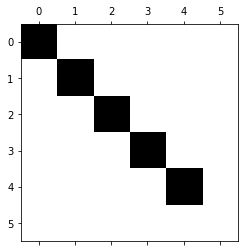

In [23]:
M = invT @ G_R @ invT.T
plt.figure(); plt.spy(M,precision=1.e-14); plt.show()

In [13]:
# the most reachable and observable new variable is this linear combination of the 
# original state variables:
print(invT[0,:])
print("the first new variable describes the mean displacement and velocity of the masses.\\
Therefore, it describes relatively more the lightest, more mobile, one.")

[-2.37776056e-05 -5.34150047e-05 -4.53059144e-05 -4.55574940e-02
 -5.19336797e-02 -2.59834985e-02]
the first new variable describes the mean displacement and velocity of the masses.\Therefore, it describes relatively more the lightest, more mobile, one.


In [14]:
# the least reachable and observable new variable is this linear combination of the 
# original state variables:
print(invT[-1,:])
print("it involves mainly the third, heaviest, mass!")

[-3.62145388e-11  9.28015757e-10 -9.18887468e-03 -1.07901028e-01
  1.67870978e-01  2.99187490e+00]
it involves mainly the third, heaviest, mass!
